In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/research/prompt_engineering/RL
!pip install tiktoken
!pip install --upgrade "httpx<0.28"
import json
import rl
import utils
from openai import OpenAI
with open("config.json") as config_file:
    config = json.load(config_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/research/prompt_engineering/RL


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The OpenAI API does not have a direct parameter to set a random seed for reproducibility in its responses. The behavior of the models is inherently non-deterministic due to randomness in the generation process.

In [2]:
VOCAL = 50000
EPOCHS = 1
PROMPT_LENGTH = 7
PROMPT_INIT = "Find material entities."
LR = 0.001
HIDDEN = 64
EXP_ID = 5
PRINT_INTERVAL = 0
SAVE = False
PLOT = False

PROMPTS, PREDICTIONS, SCORES, REWARDS = rl.do_training(
    prompt_init=PROMPT_INIT, epochs=EPOCHS, learning_rate=LR,
    vocal_size=VOCAL, prompt_length=PROMPT_LENGTH, hidden=HIDDEN,
    exp_id=EXP_ID, print_interval=PRINT_INTERVAL, save_results=SAVE, plot=PLOT,
    client=OpenAI(api_key=config["OPENAI_API_KEY"])
    )

Initial prompt: Find material entities.
Predictions: [['vanadium dioxide', ' graphene', ' dielectric film', ' gold'], ['electronic components', ' ambient sound', ' phononic crystals', ' acoustic metamaterials', ' piezoelectric materials', ' defect mode metamaterial', ' Gradient Index (GRIN) system', ' topological metamaterial'], ['Douglas fir wood', ' metamaterial catalysts', ' microlattices', ' bimodal pores', ' 316L stainless steel', ' Fe', ' Co']]
Scores: [0.5454545454545454, 0.7692307692307693, 0.6666666666666666]
Reward: 0.6604506604506604



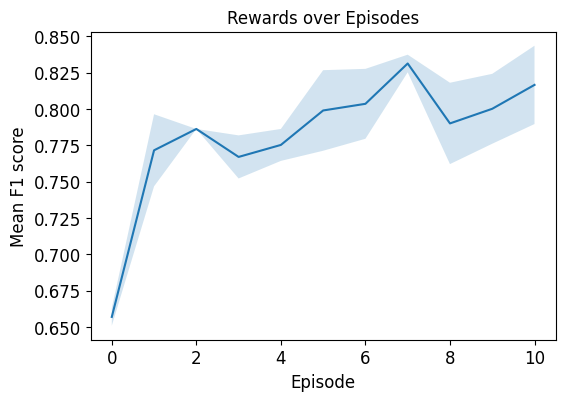

In [3]:
all_results = utils.load_results("Find material entities._e_10_l_0.001_v_50000_len_7_h_64_s_1234_")
utils.plot_results(all_results, fontsize=12, figsize=(6, 4))